# WildBerryEye — Single-Day, 100ms Binning Analysis

Change the `DATE` parameter below to the day you want to analyze.


In [237]:
# Cell 1: Imports & Configuration

import re
from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# ─── USER PARAMETERS ──────────────────────────────────────────────────────────
DATE     = "2025-05-20"   # ← change to the date-folder you want
# This notebook lives in wildberryeye/analysis/, so data is in:
BASE_DIR = Path.cwd() / "data" / DATE
BIN_FREQ = "100ms"            # 'S' = 1-second bins
# ──────────────────────────────────────────────────────────────────────────────

print("Looking in:", BASE_DIR)
if not BASE_DIR.exists():
    raise FileNotFoundError(f"Data folder not found: {BASE_DIR}")



Looking in: d:\Documents\Master\wildberryeye\analysis\data\2025-05-20


## 1. Filename Parsing (Timestamp + Metadata)

Filenames are now like:

object_20250514-093015-123456_wildberry01_root_CONF55_IOU65.jpg

motion_20250514-093016-223344_wildberry02_root_THRESH25_AREA500.jpg

We’ll pull out:
- **timestamp** (YYYYMMDD-HHMMSS)  
- **camera** (e.g. `wildberry01`)  
- **user** (e.g. `root`)  
- **any numeric params** (`CONF=55`, `IOU=65`, `THRESH=25`, `AREA=500`)


In [238]:
# Cell 2 (revised): Regex & parser with microseconds

from datetime import datetime

def parse_filename(img_path: Path):
    """
    Now handles stems like:
      object_20250512-093015-945726_wildberry01_...
    where 945726 is the microsecond part.
    """
    stem = img_path.stem
    parts = stem.split('_')
    if len(parts) < 4:
        return None

    kind   = parts[0]
    dt_str = parts[1]           # e.g. "20250512-093015-945726"
    dt_fields = dt_str.split('-')
    if len(dt_fields) < 2:
        return None
    date_str, time_str = dt_fields[0], dt_fields[1]

    # parse base up to seconds
    try:
        ts = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")
    except ValueError:
        return None

    # if there is a third part, treat it as microseconds
    if len(dt_fields) >= 3:
        micro = dt_fields[2]
        # pad/truncate to 6 digits
        micro = (micro + "000000")[:6]
        ts = ts.replace(microsecond=int(micro))

    camera, user = parts[2], parts[3]
    # parse any PARAM123 bits as before...
    params = {}
    for p in parts[4:]:
        m = re.match(r"([A-Za-z]+)(\d+)", p)
        if m:
            k, v = m.groups()
            params[k] = int(v)

    rec = {"timestamp": ts, "kind": kind, "camera": camera, "user": user}
    rec.update(params)
    return rec


## 2. Load All Records for the Day

Build a single DataFrame with one row per image, including its metadata.


In [239]:
# Cell 3: Gather Records

records = []
for kind in ("object", "motion"):
    folder = BASE_DIR / kind
    if not folder.is_dir():
        continue
    for img in sorted(folder.iterdir()):
        if img.suffix.lower() not in (".jpg", ".jpeg"):
            continue
        meta = parse_filename(img)
        if meta:
            records.append(meta)

if not records:
    raise RuntimeError("No valid records found—check filenames & folders.")

df = pd.DataFrame(records)
print(df.head())
print(df.kind.value_counts())


                   timestamp    kind       camera  user  CONF   IOU  THRESH  \
0 2025-05-20 11:49:04.641392  object  wildberry01  root  55.0  65.0     NaN   
1 2025-05-20 11:49:04.775981  object  wildberry01  root  55.0  65.0     NaN   
2 2025-05-20 11:49:04.904637  object  wildberry01  root  55.0  65.0     NaN   
3 2025-05-20 11:49:05.037575  object  wildberry01  root  55.0  65.0     NaN   
4 2025-05-20 11:49:05.172740  object  wildberry01  root  55.0  65.0     NaN   

   AREA  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  
object    6071
motion    2209
Name: kind, dtype: int64


## 3. Bin Counts at 100ms Resolution

Convert timestamps to Series, floor to seconds, then count.


In [240]:
# Cell 4 (re‐run with sub‐second bins):

# Floor to 200 ms bins
df["ts_floor"] = pd.to_datetime(df["timestamp"]).dt.floor(freq=BIN_FREQ)

# count per‐bin
obj_counts = df[df.kind=="object"].groupby("ts_floor").size()
mot_counts = df[df.kind=="motion"].groupby("ts_floor").size()

# full index with 200 ms steps
full_idx = pd.date_range(
    start=df.ts_floor.min(),
    end  =df.ts_floor.max(),
    freq =BIN_FREQ)

obj_full = obj_counts.reindex(full_idx, fill_value=0)
mot_full = mot_counts.reindex(full_idx, fill_value=0)


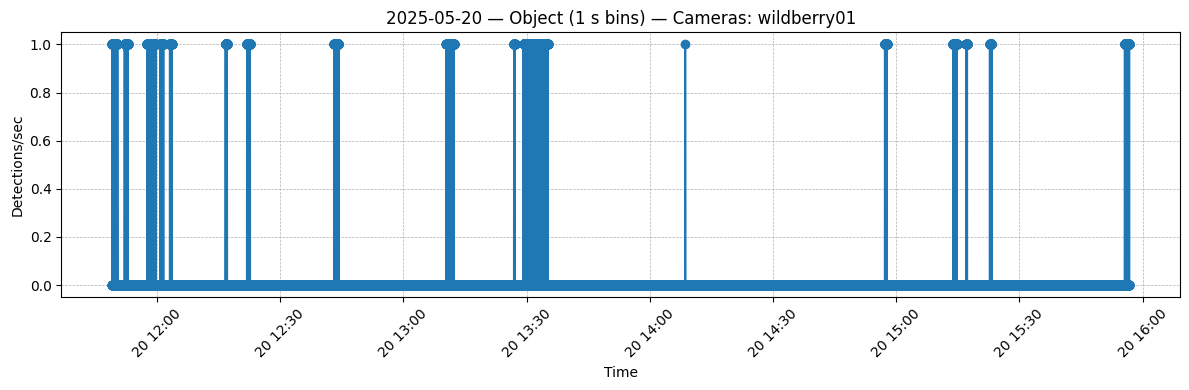

In [241]:
# Cell 5: Object-Only Plot

plt.figure(figsize=(12,4))
plt.plot(obj_full.index, obj_full.values,
         marker="o", linestyle="-", label="Object")
plt.title(f"{DATE} — Object (1 s bins) — Cameras: {obj_cams}")
plt.xlabel("Time")
plt.ylabel("Detections/sec")
plt.xticks(rotation=45)
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()


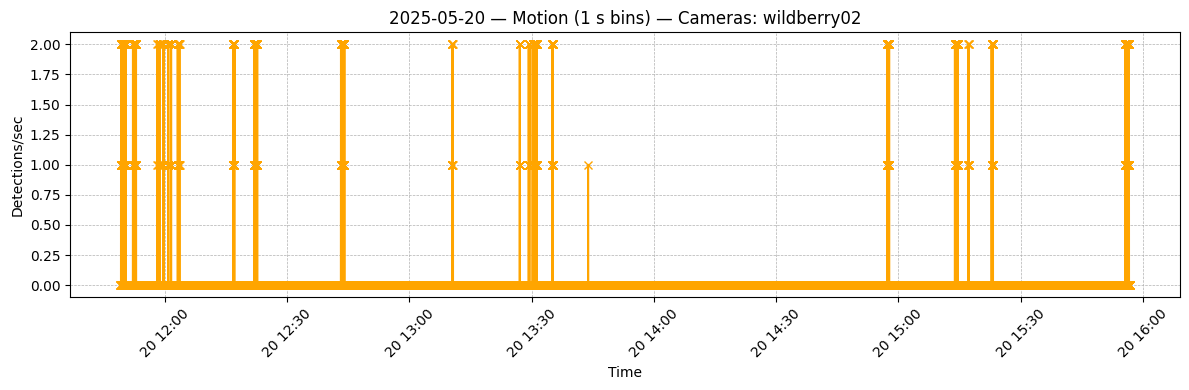

In [242]:
# Cell 6: Motion-Only Plot

plt.figure(figsize=(12,4))
plt.plot(mot_full.index, mot_full.values,
         marker="x", linestyle="-", color="orange", label="Motion")
plt.title(f"{DATE} — Motion (1 s bins) — Cameras: {mot_cams}")
plt.xlabel("Time")
plt.ylabel("Detections/sec")
plt.xticks(rotation=45)
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()


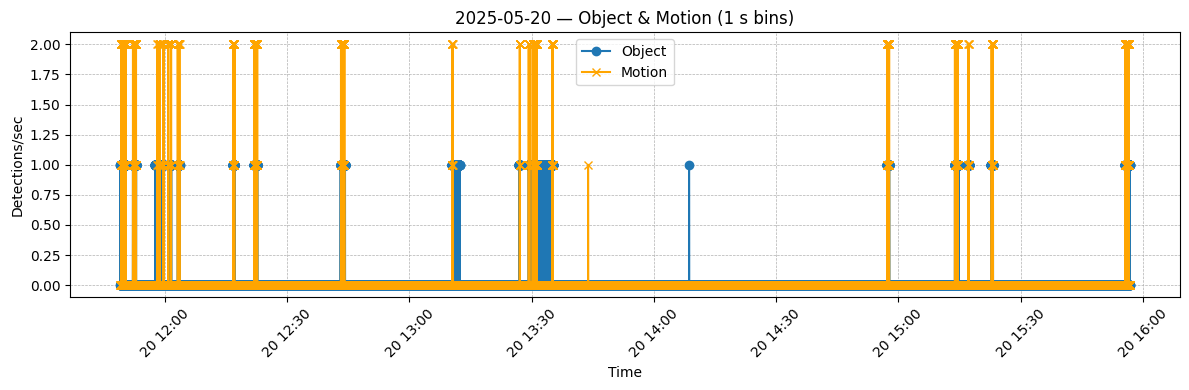

In [243]:
# Cell 7: Overlay Object & Motion

plt.figure(figsize=(12,4))
plt.plot(obj_full.index, obj_full.values,
         marker="o", linestyle="-", label="Object")
plt.plot(mot_full.index, mot_full.values,
         marker="x", linestyle="-", color="orange", label="Motion")
plt.title(f"{DATE} — Object & Motion (1 s bins)")
plt.xlabel("Time")
plt.ylabel("Detections/sec")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

In [244]:
# Cell 8: Tunable Cluster‐based Event Detection

# ─── TUNING PARAMETERS ──────────────────────────────────────────────────────────
DET_THRESH = 1    # bins with <2 detections/sec are considered inactive
GAP_SEC    = 60   # seconds of inactivity that break events
MIN_COUNT  = 5    # an event must contain ≥5 total detections
# ──────────────────────────────────────────────────────────────────────────────

# 1) Build a list of “active” seconds above threshold
mask = obj_full >= DET_THRESH
det_times = obj_full.index[mask]

# 2) Cluster those times into events by gap threshold
def detect_events_by_gap(times, gap_sec):
    events = []
    if len(times) == 0:
        return events
    start = times[0]
    prev  = times[0]
    for curr in times[1:]:
        if (curr - prev).total_seconds() > gap_sec:
            events.append((start, prev))
            start = curr
        prev = curr
    events.append((start, prev))
    return events

raw_events = detect_events_by_gap(det_times, GAP_SEC)

# 3) Filter by total count within each event
events = []
for s, e in raw_events:
    total = obj_full[s:e].sum()
    if total >= MIN_COUNT:
        events.append((s, e))

print(f"Found {len(events)} events "
      f"(DET_THRESH={DET_THRESH}, GAP_SEC={GAP_SEC}, MIN_COUNT={MIN_COUNT}):")
for i, (s, e) in enumerate(events, 1):
    print(f"  Event {i}: {s} → {e}  (total={obj_full[s:e].sum()})")


Found 16 events (DET_THRESH=1, GAP_SEC=60, MIN_COUNT=5):
  Event 1: 2025-05-20 11:49:04.600000 → 2025-05-20 11:50:19.900000  (total=362)
  Event 2: 2025-05-20 11:52:07.300000 → 2025-05-20 11:52:54.300000  (total=267)
  Event 3: 2025-05-20 11:57:36.400000 → 2025-05-20 11:59:36.900000  (total=578)
  Event 4: 2025-05-20 12:00:47 → 2025-05-20 12:01:31.300000  (total=332)
  Event 5: 2025-05-20 12:03:07.700000 → 2025-05-20 12:03:33.900000  (total=197)
  Event 6: 2025-05-20 12:16:42.400000 → 2025-05-20 12:17:02.100000  (total=149)
  Event 7: 2025-05-20 12:21:54.300000 → 2025-05-20 12:22:38.200000  (total=252)
  Event 8: 2025-05-20 12:43:06.200000 → 2025-05-20 12:44:10.400000  (total=201)
  Event 9: 2025-05-20 13:10:29.100000 → 2025-05-20 13:12:17.400000  (total=594)
  Event 10: 2025-05-20 13:26:55.600000 → 2025-05-20 13:27:05.300000  (total=74)
  Event 11: 2025-05-20 13:29:14.900000 → 2025-05-20 13:35:08  (total=1993)
  Event 12: 2025-05-20 14:57:13.800000 → 2025-05-20 14:57:43.200000  (total

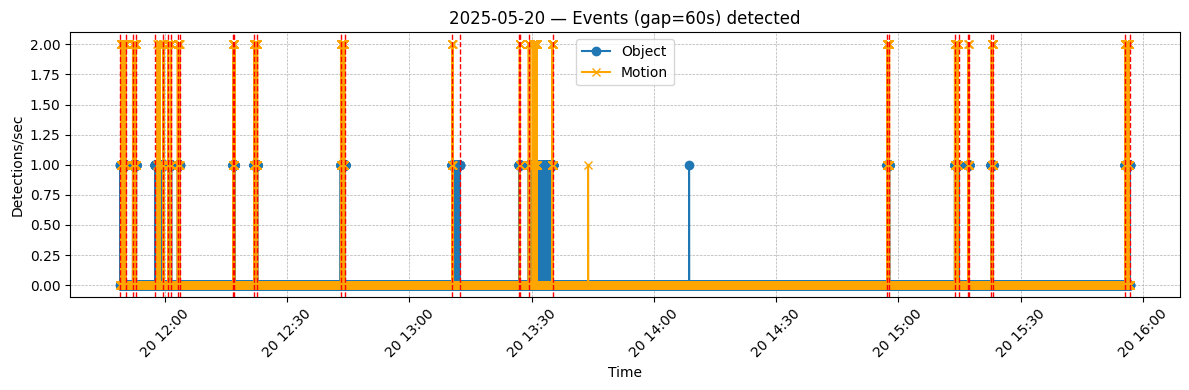

In [245]:
# Cell 9: Overlay Object & Motion with Detected Events

plt.figure(figsize=(12,4))
plt.plot(obj_full.index, obj_full.values,
         marker="o", linestyle="-", label="Object")
plt.plot(mot_full.index, mot_full.values,
         marker="x", linestyle="-", color="orange", label="Motion")

for s,e in events:
    plt.axvline(s, color="red", linestyle="--", linewidth=1)
    plt.axvline(e, color="red", linestyle="--", linewidth=1)

plt.title(f"{DATE} — Events (gap={GAP_SEC}s) detected")
plt.xlabel("Time")
plt.ylabel("Detections/sec")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()



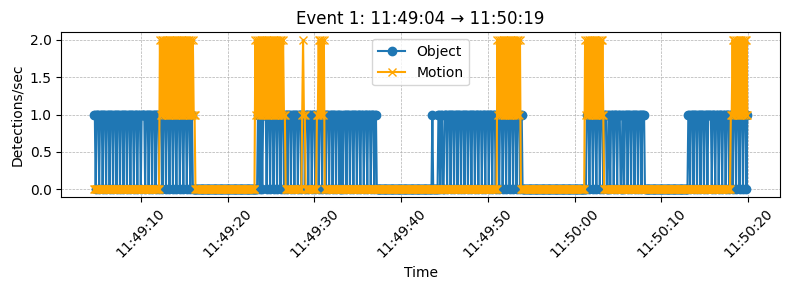

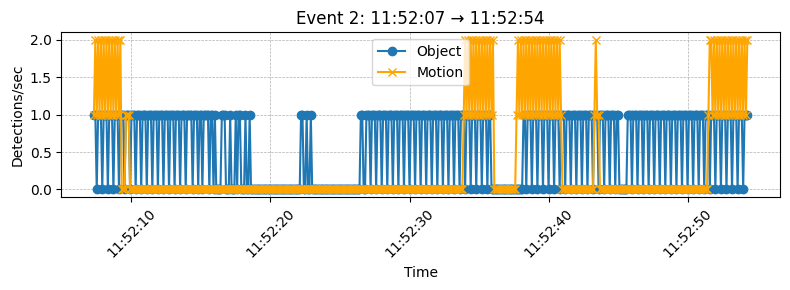

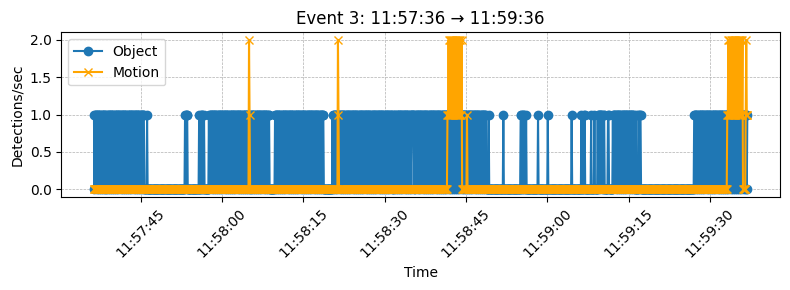

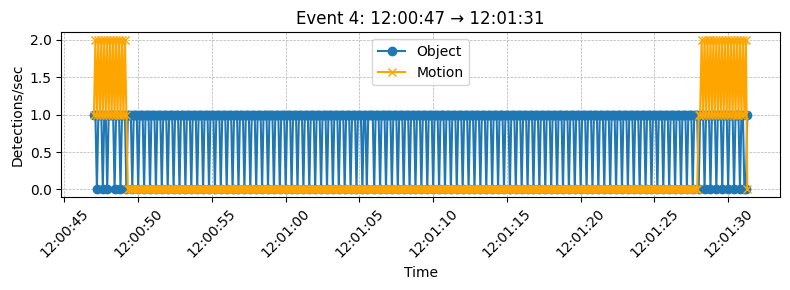

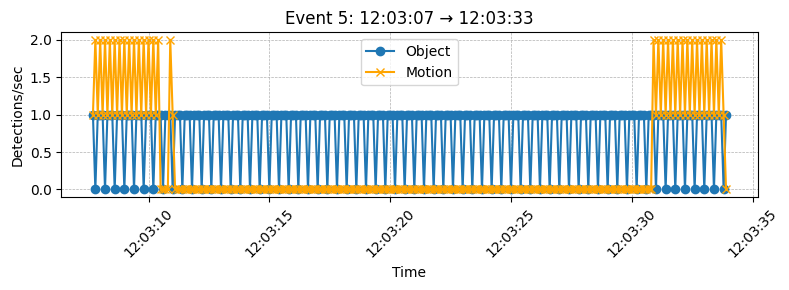

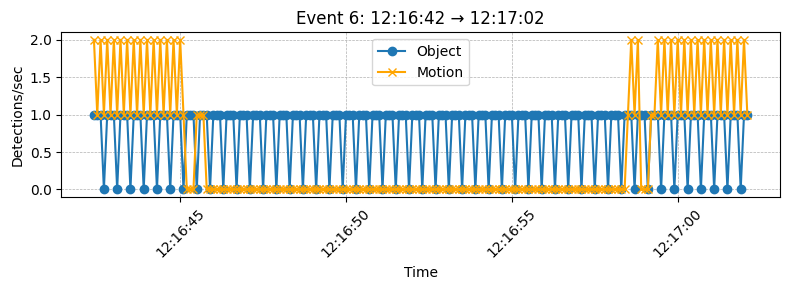

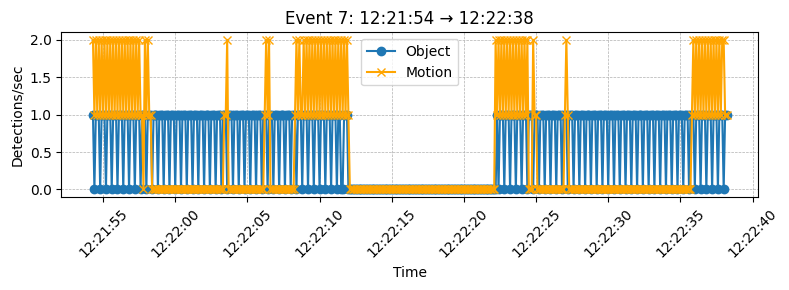

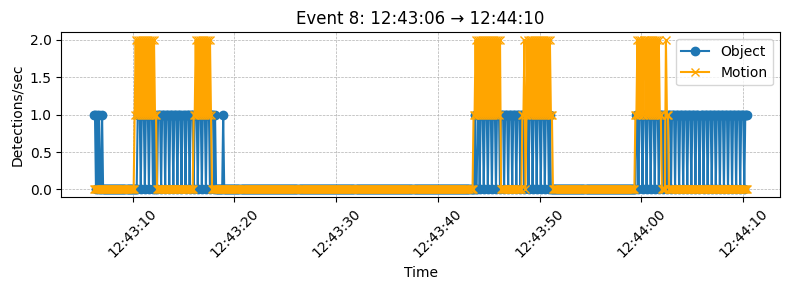

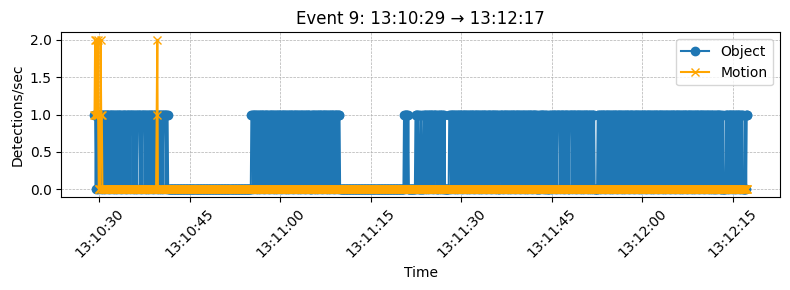

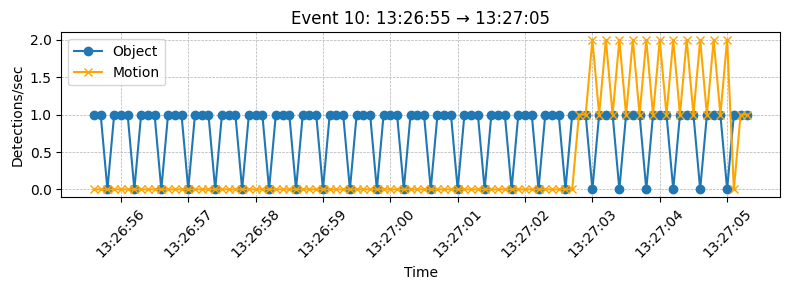

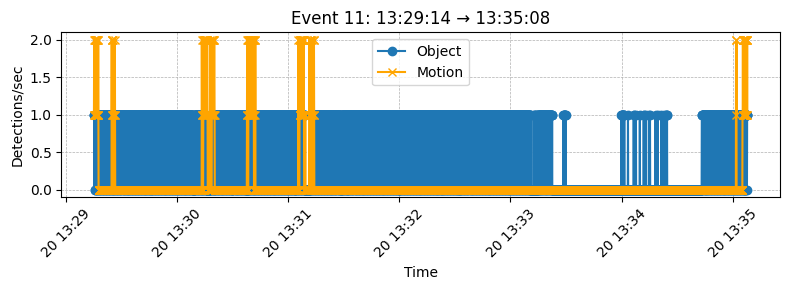

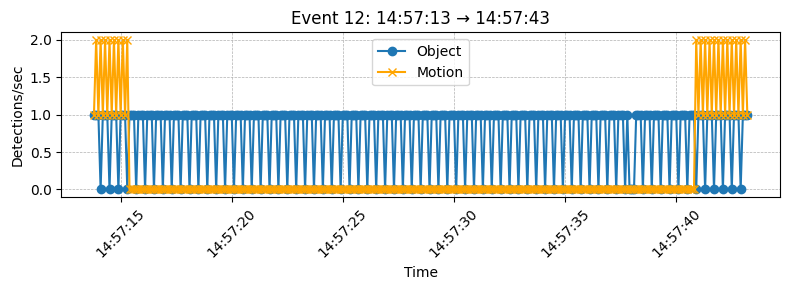

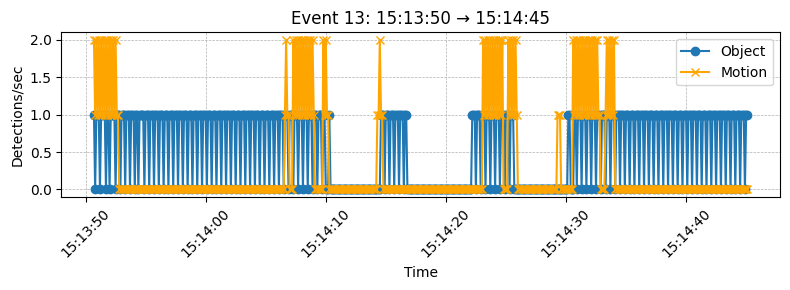

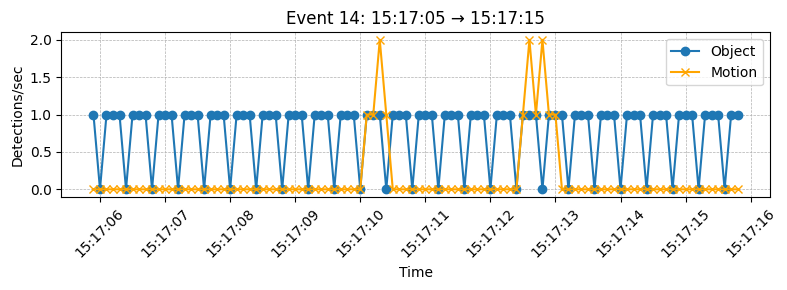

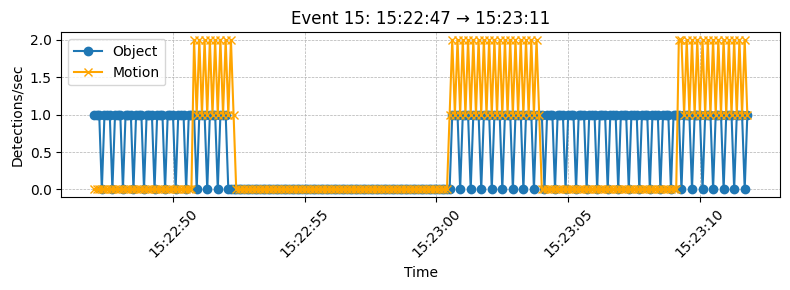

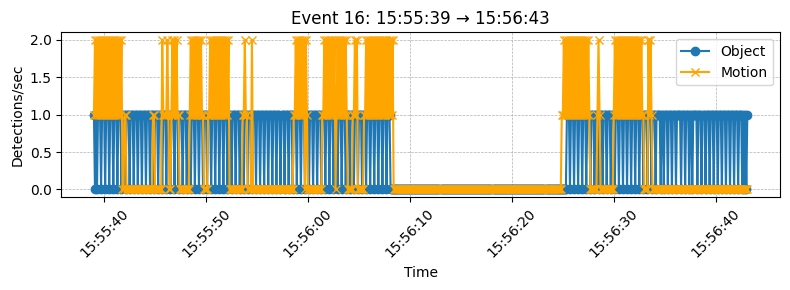

In [246]:
# Cell X: Plot Each Event Independently

for i, (start, end) in enumerate(events, 1):
    # Slice out just this event’s window
    obj_slice = obj_full[start:end]
    mot_slice = mot_full[start:end]

    plt.figure(figsize=(8,3))
    plt.plot(obj_slice.index, obj_slice.values,
             marker="o", linestyle="-", label="Object")
    plt.plot(mot_slice.index, mot_slice.values,
             marker="x", linestyle="-", color="orange", label="Motion")

    plt.title(f"Event {i}: {start.strftime('%H:%M:%S')} → {end.strftime('%H:%M:%S')}")
    plt.xlabel("Time")
    plt.ylabel("Detections/sec")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()


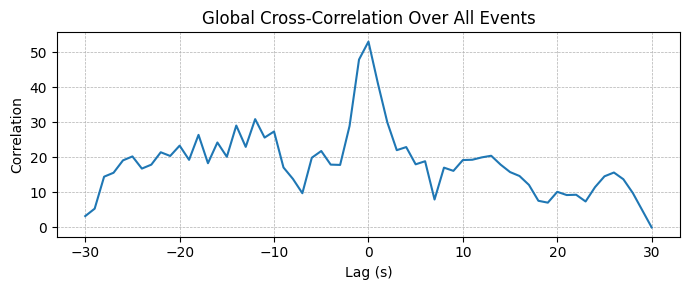

In [247]:
# Cell Y: Global Cross-Corr on All Events

import numpy as np

# 1) Build concatenated arrays of object and motion counts, only during events
obj_ev = []
mot_ev = []
for start, end in events:
    rng = pd.date_range(start, end, freq="S")
    obj_ev.append(obj_full.reindex(rng, fill_value=0).values)
    mot_ev.append(mot_full.reindex(rng, fill_value=0).values)

# flatten into one long sequence
obj_seq = np.concatenate(obj_ev)
mot_seq = np.concatenate(mot_ev)

# 2) subtract means and correlate
obj_c = obj_seq - obj_seq.mean()
mot_c = mot_seq - mot_seq.mean()
xc_full = np.correlate(obj_c, mot_c, mode="full")

# 3) build lag axis in seconds
lags = np.arange(-len(obj_seq)+1, len(obj_seq))

# 4) plot a reasonable window around zero (e.g. ±30 s)
win = 30
mask = (lags >= -win) & (lags <= win)

plt.figure(figsize=(7,3))
plt.plot(lags[mask], xc_full[mask])
plt.title("Global Cross-Correlation Over All Events")
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Cell X: Build & show combined side-by-side GIF per event

import imageio
from PIL import Image
from IPython.display import HTML, display

# Directories (notebook running in analysis/)
OBJ_DIR = Path.cwd() / "data" / DATE / "object"
MOT_DIR = Path.cwd() / "data" / DATE / "motion"
OUT_DIR = Path.cwd() / "data" / DATE

# Preview settings
MAX_FRAMES     = 20      # cap preview length
FRAME_DURATION = 0.2     # seconds per frame

def equalize_list(files, target_len):
    n = len(files)
    if n >= target_len:
        return [files[int(round(i*(n-1)/(target_len-1)))] for i in range(target_len)]
    else:
        reps = target_len // n
        rem  = target_len % n
        return files*reps + files[:rem]

for i, (start, end) in enumerate(events, 1):
    # collect files in window
    obj_files = []
    for p in sorted(OBJ_DIR.iterdir()):
        if p.suffix.lower() in (".jpg","jpeg"):
            meta = parse_filename(p)
            if meta and start <= meta["timestamp"] <= end:
                obj_files.append(p)
    mot_files = []
    for p in sorted(MOT_DIR.iterdir()):
        if p.suffix.lower() in (".jpg","jpeg"):
            meta = parse_filename(p)
            if meta and start <= meta["timestamp"] <= end:
                mot_files.append(p)

    if not obj_files or not mot_files:
        continue

    # determine how many frames
    raw_max = max(len(obj_files), len(mot_files))
    target  = raw_max if raw_max<=MAX_FRAMES else MAX_FRAMES

    # equalize lengths
    obj_eq = equalize_list(obj_files, target)
    mot_eq = equalize_list(mot_files, target)

    # build combined frames
    combined = []
    for of, mf in zip(obj_eq, mot_eq):
        im_o = Image.open(of)
        im_m = Image.open(mf)
        w1,h1 = im_o.size
        w2,h2 = im_m.size
        H  = max(h1,h2)
        # new canvas
        canvas = Image.new("RGB", (w1+w2, H))
        canvas.paste(im_o, (0, 0))
        canvas.paste(im_m, (w1, 0))
        combined.append(canvas)

    # save as one GIF
    out_gif = OUT_DIR / f"event_{i:02d}_combined.gif"
    combined[0].save(
        out_gif,
        format="GIF",
        save_all=True,
        append_images=combined[1:],
        duration=int(FRAME_DURATION*1000),
        loop=0
    )

    # display inline
    display(HTML(f"""
      <h4>Event {i}: {start.time()} → {end.time()}</h4>
      <img src="{out_gif}" />
    """))



d:\Documents\Master\wildberryeye\.venv\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
d:\Documents\Master\wildberryeye\.venv\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,


Object GIF,Motion GIF
,
